# Modeling Phase – Baseline & Classical Models

In this notebook, we:

- Implement naive and moving average baseline forecasts to establish reference performance.
- Build and evaluate ARIMA/SARIMA models on the target energy consumption time series.
- Compare results using standard metrics (MAE, RMSE, MAPE, R²).


# Libraries

In [14]:
# System & Data Handling
# import os
# import shutil
import pickle

# Data Loading
# import kagglehub
import pandas as pd

# Plotting & Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
# import calendar

# Time Series Analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Constants
FIGSIZE = (16, 5)
FIGSIZE_LONG=(20, 6)

## Loading cleaned data
Loading the cleaned data from EDA phase

In [15]:
with open('../data/data_cleaned.pkl', 'rb') as f:
    data_cleaned = pickle.load(f)

df_data = data_cleaned['df_data']
df_data.head()


,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption,Date,Time,DayOfWeek_ext,RollingMean
Timestamp,,,,,,,,,,,,,,
2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373,2022-01-01,0,Saturday,NaN
2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855,2022-01-01,1,Saturday,NaN
2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888,2022-01-01,2,Saturday,NaN
2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850,2022-01-01,3,Saturday,NaN
2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732,2022-01-01,4,Saturday,NaN


In [16]:

df_data_24h_complete = data_cleaned['df_data_24h_complete']
df_data_24h_complete.head()


,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption,Date,Time,DayOfWeek_ext
Timestamp,,,,,,,,,,,,,
2022-01-04 00:00:00,25.080881,59.671534,1897.702224,8,Off,Off,14.391800,Friday,No,75.913906,2022-01-04,0,Tuesday
2022-01-04 01:00:00,25.792512,33.892216,1849.829581,7,On,Off,25.875969,Wednesday,Yes,84.191467,2022-01-04,1,Tuesday
2022-01-04 02:00:00,26.386079,43.295778,1851.597741,5,On,Off,17.471965,Sunday,Yes,75.251764,2022-01-04,2,Tuesday
2022-01-04 03:00:00,22.140257,49.424878,1037.206885,7,Off,On,3.329908,Tuesday,Yes,75.014471,2022-01-04,3,Tuesday
2022-01-04 04:00:00,24.175776,41.800150,1198.625224,6,Off,Off,18.470624,Sunday,No,69.365745,2022-01-04,4,Tuesday


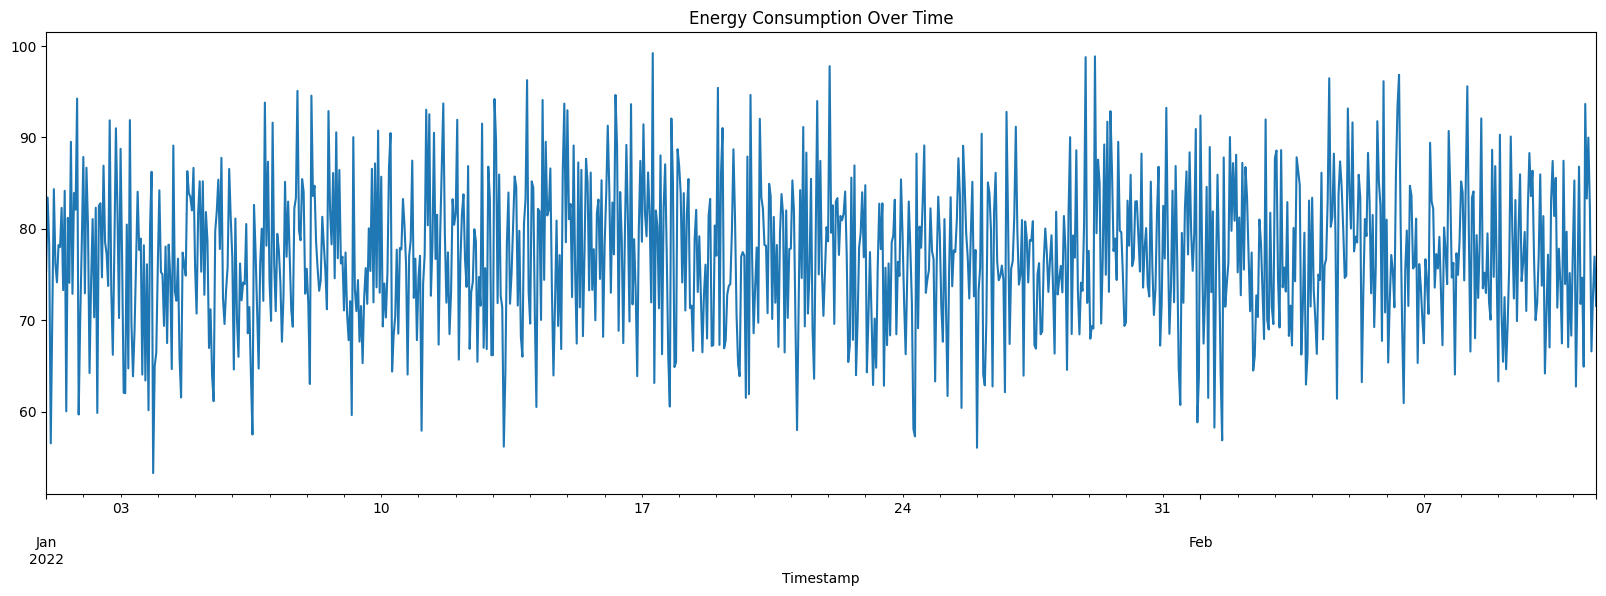

In [17]:
df_data['EnergyConsumption'].plot(title="Energy Consumption Over Time", figsize=FIGSIZE_LONG)
plt.show()

# Utility functions:
- Evaluation of prediction using the metrics, MAE, RMSE, MAPE, and R2
- Visualizaiton of the training, test, and prediction samples

In [18]:

def evaluate_model(df_predictions, verbose=True):
    y_pred = df_predictions['prediction'].values
    y_true = df_predictions['truth'].values

    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2   = r2_score(y_true, y_pred)

    if verbose:
        print("Rolling-Window Forecast Evaluation:")
        print(f"MAE:  {mae:.3f}")
        print(f"RMSE: {rmse:.3f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"R2:   {r2:.4f}")

    results = {
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'r2': r2
    }

    return results

def visualize_prediction(df_predictions, df_data, title, last_n_samples=48):
    # Visualize the prediction
    df_viz = df_data.iloc[-last_n_samples:].copy()
    plt.figure(figsize=(12, 5))
    plt.plot(df_viz.index, df_viz['EnergyConsumption'],  label="Training Data",    marker='o')
    plt.plot(df_predictions.index, df_predictions['truth'],  label="Test Data",    marker='o')
    plt.plot(df_predictions.index, df_predictions['prediction'],  label="Forecast",  marker='x', linestyle='--')
    plt.title(title)
    plt.xlabel("Timestamp")
    plt.ylabel("Energy Consumption")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Test/ Train data split

In [19]:
# import numpy as np

forecast_horizon = 24
target_col = 'EnergyConsumption'
train_hr = df_data.iloc[:-forecast_horizon][target_col].asfreq('h')
test_hr = df_data.iloc[-forecast_horizon:][target_col].asfreq('h')

forecast_horizon = 7
df_daily = df_data_24h_complete['EnergyConsumption'].resample('D').sum()
df_daily = df_daily.to_frame()
train_day = df_daily.iloc[:-forecast_horizon][target_col].asfreq('D')
test_day = df_daily.iloc[-forecast_horizon:][target_col].asfreq('D')


# Baseline model - moving average
We use the moving average model and a rolling windows on the past samples to predict the next sample of the data

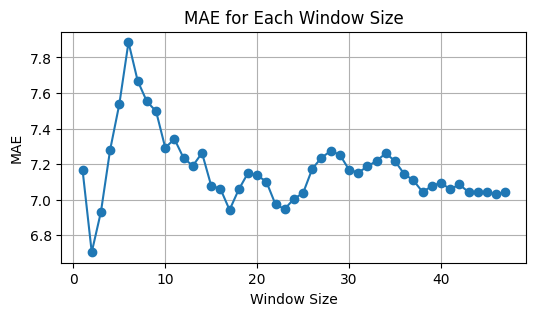

The best window size is 2 with a MAE of 6.70%
Rolling-Window Forecast Evaluation:
MAE:  6.704
RMSE: 68.051
MAPE: 8.75%
R2:   -0.0125


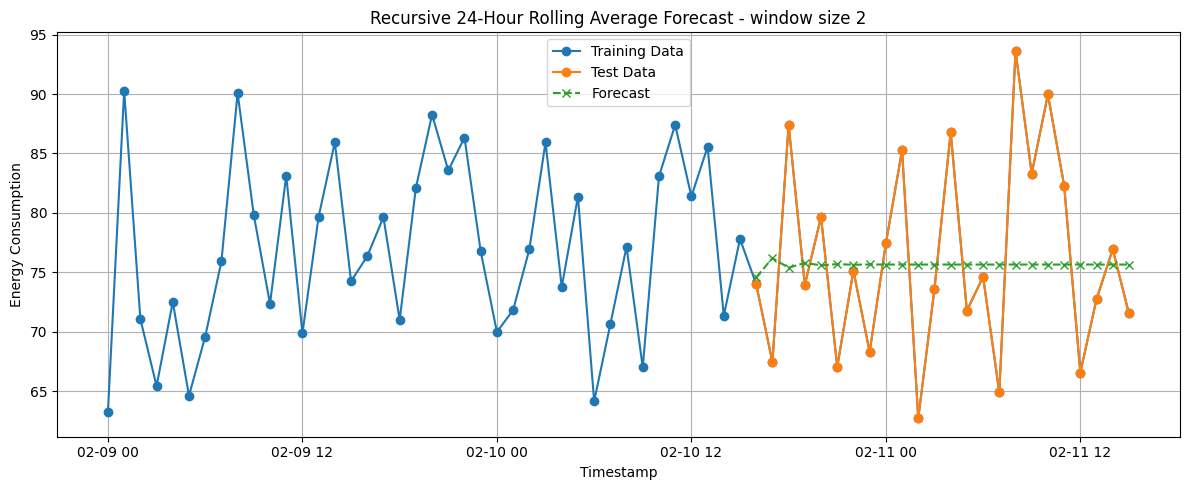

In [28]:
# Rolling window of data for each 24 samples

def rolling_window_forecast(train, test, window_size, verbose=False):

    df_predictions = pd.DataFrame(index=test.index, columns=['prediction', 'truth'])
    df_predictions['truth'] = test.values

    history = train.iloc[-window_size:].tolist()

    for ts in df_predictions.index:
        next_pred = np.mean(history[-window_size:])
        df_predictions.loc[ts, 'prediction'] = next_pred
        history.append(next_pred)
    
    results = evaluate_model(df_predictions, verbose=verbose)
    
    return df_predictions, results

import matplotlib.pyplot as plt

def grid_search_rolling_window_forecast(train, test, param_range=range(1, 24)):
    # collect (window_size, mape) for each trial
    results = []

    for window_size in param_range:
        if window_size > len(train):
            print(f"Window size {window_size} is greater than the training data length {len(train)}")
            continue

        df_pred, metrics = rolling_window_forecast(train, test, window_size)
        results.append((window_size, metrics['mae']))

    # unpack into two lists if you still want to plot
    window_sizes, mapes = zip(*results)

    # plot the MAPE for each window size
    plt.figure(figsize=(6, 3))
    plt.plot(window_sizes, mapes, marker='o')
    plt.xlabel("Window Size")
    plt.ylabel("MAE")
    plt.title("MAE for Each Window Size")
    plt.grid(True)
    plt.show()

    # find the (window_size, mape) tuple with smallest mape
    best_window, best_mape = min(results, key=lambda x: x[1])
    print(f"The best window size is {best_window} with a MAE of {best_mape:.2f}%")

    return best_window, best_mape, results


window_size_best, min_mape, all_mape = grid_search_rolling_window_forecast(train_hr, test_hr, param_range=range(1, 48))

# prediction with the best forecast horizon
df_predictions_baseline, results_baseline = rolling_window_forecast(train_hr, test_hr, window_size_best, verbose=True)

# Visualize the prediction
title = f"Recursive 24-Hour Rolling Average Forecast - window size {window_size_best}"
visualize_prediction(df_predictions_baseline, df_data, title, last_n_samples=64)


## Baseline - daily prediciton

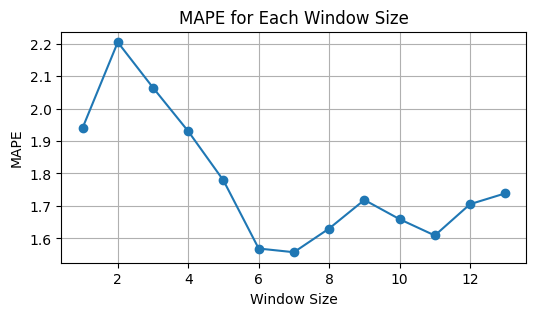

The best window size is 7 with a MAPE of 1.56%
Rolling-Window Forecast Evaluation:
MAE:  29.422
RMSE: 1391.545
MAPE: 1.56%
R2:   -0.1345


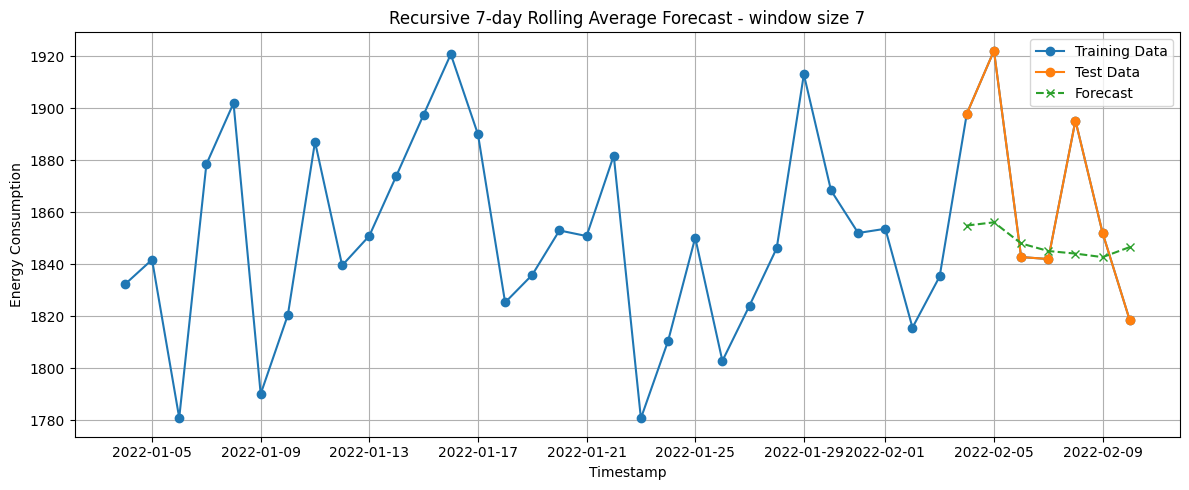

,Baseline_24h,Baseline_Daily
mae,6.704103,29.422096
rmse,68.050988,1391.544903
mape,8.750275,1.557443
r2,-0.012465,-0.134533


In [8]:

window_size_best, min_mape, all_mape = grid_search_rolling_window_forecast(train_day, test_day, range(1, 14))

df_predictions, results_baseline_daily = rolling_window_forecast(train_day, test_day, window_size_best, verbose=True)
# Visualize the prediction
title = f"Recursive 7-day Rolling Average Forecast - window size {window_size_best}"
visualize_prediction(df_predictions, df_daily, title, last_n_samples=64)

df_model_results = pd.DataFrame({'Baseline_24h':results_baseline, 'Baseline_Daily':results_baseline_daily})
df_model_results


# ARIMA model

In [9]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
import matplotlib.pyplot as plt
from itertools import product

def arima_model(train, test, order):
    ''' This function fits an ARIMA model to the training data and returns a dataframe of the predictions and the true values.
    Args:
        train: pd.Series, the training data
        test: pd.Series, the test data
        order: tuple, the order of the ARIMA model (p,d,q)
    Returns:
        df_predictions: pd.DataFrame, the predictions and the true values
    '''
    # Fit ARIMA with selected order
    model = ARIMA(train, order=order)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", 
            message=".*divide by zero encountered.*|.*overflow encountered.*|.*invalid value encountered.*|.*Using zeros.*|.*Maximum Likelihood optimization*.")
        model_fit = model.fit()
    
    
    forecast_horizon = len(test)
    # Forecast
    forecast = model_fit.forecast(steps=forecast_horizon)

    # Wrap into dataframe for evaluation
    df_predictions = pd.DataFrame(index=test.index)
    df_predictions['prediction'] = forecast.values 
    df_predictions['truth'] = test.values

    return df_predictions

def extract_best_params(all_results, labels, errors, figsize=FIGSIZE_LONG, metric = 'mape'):
        plt.figure(figsize=figsize)
        plt.plot(labels, errors, marker='o')
        plt.xticks(rotation=90, ha='right')
        plt.xlabel("ARIMA(p,d,q) order")
        plt.ylabel(f"{metric}")
        plt.title(f"ARIMA Grid Search — {metric} by Order")
        plt.tight_layout()
        plt.grid(True)
        plt.show()

        # pick the best
        best_order, best_mape = min(all_results, key=lambda x: x[1])
        return best_order, best_mape

def grid_search_arima(train, test,
                      p_range=range(0, 10),
                      d_range=range(0, 2),
                      q_range=range(0, 10), figsize=FIGSIZE_LONG, metric = 'mape'):
    """
    Grid‐search ARIMA(p,d,q) by evaluating MAPE on the hold‐out `test` set.
    Returns: best_order, best_mape, all_results
      - best_order: tuple (p,d,q)
      - best_mape:   float
      - all_results: list of (order, mape)
    """
    all_results = []
    for p, d, q in product(p_range, d_range, q_range):
        order = (p, d, q)
        # print(f"Fitting ARIMA({order})")
        # fit & forecast
        df_pred = arima_model(train, test, order)        
        m = evaluate_model(df_pred, verbose=False)
        all_results.append((order, m[metric]))

    # unpack for plotting
    orders, errors = zip(*all_results)

    # convert orders to a string for x‐axis labels
    labels = [f"{o[0]},{o[1]},{o[2]}" for o in orders]    
    
    best_order, best_mape = extract_best_params(all_results, labels, errors, figsize, metric)

    print(f"Best ARIMA order: {best_order} → {metric} = {best_mape:.2f}")
    return best_order, best_mape, all_results


## 24 hour forcast

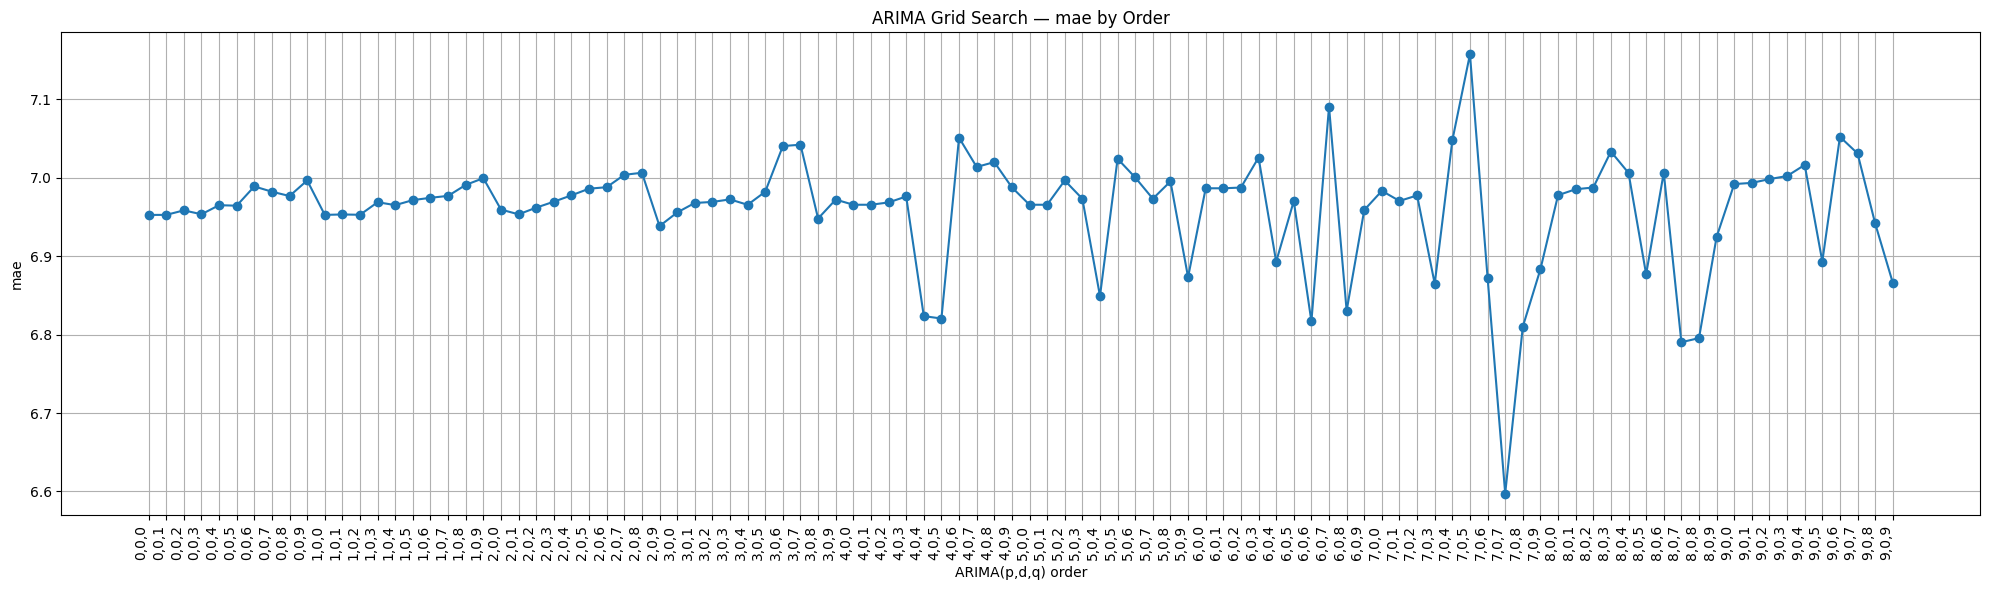

Best ARIMA order: (7, 0, 7) → mae = 6.60
Rolling-Window Forecast Evaluation:
MAE:  6.597
RMSE: 64.993
MAPE: 8.77%
R2:   0.0330


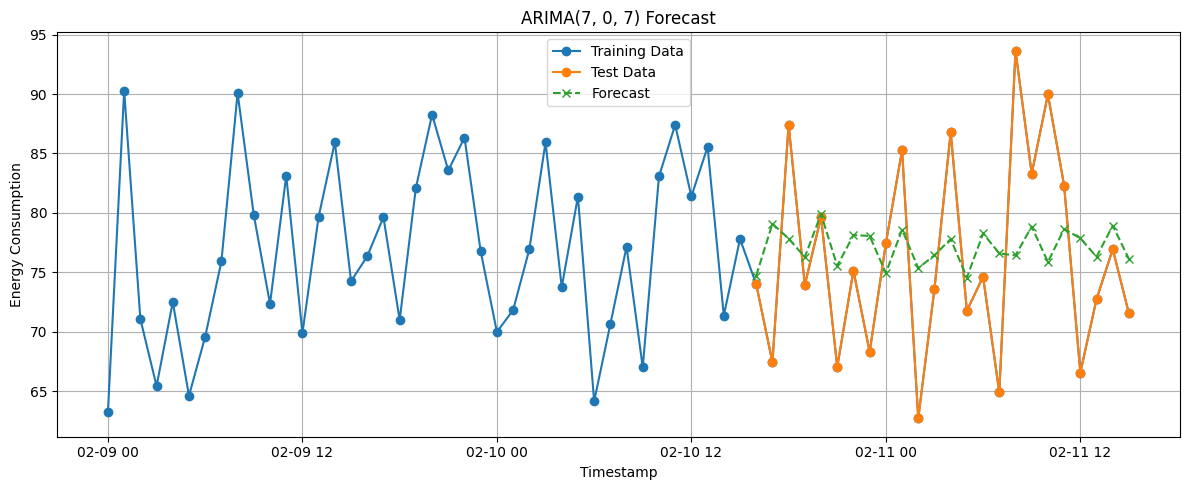

,Baseline_24h,Baseline_Daily,ARIMA_24h,ARIMA_Daily
mae,6.704103,29.422096,6.597422,20.979117
rmse,68.050988,1391.544903,64.993160,719.619933
mape,8.750275,1.557443,8.768055,1.122592
r2,-0.012465,-0.134533,0.033029,0.413290


In [25]:
# --- USAGE ---
best_order, best_mape, results = grid_search_arima(
    train_hr,
    test_hr,
    p_range=range(0,10),
    d_range=[0],
    q_range=range(0,10),
    metric='mae'
)

df_predictions = arima_model(train_hr, test_hr, best_order)
result_arima =  evaluate_model(df_predictions, verbose=True)
visualize_prediction(df_predictions, df_data, title=f"ARIMA{best_order} Forecast", last_n_samples=64)
df_model_results['ARIMA_24h'] = result_arima
df_model_results


## 7-day forcast

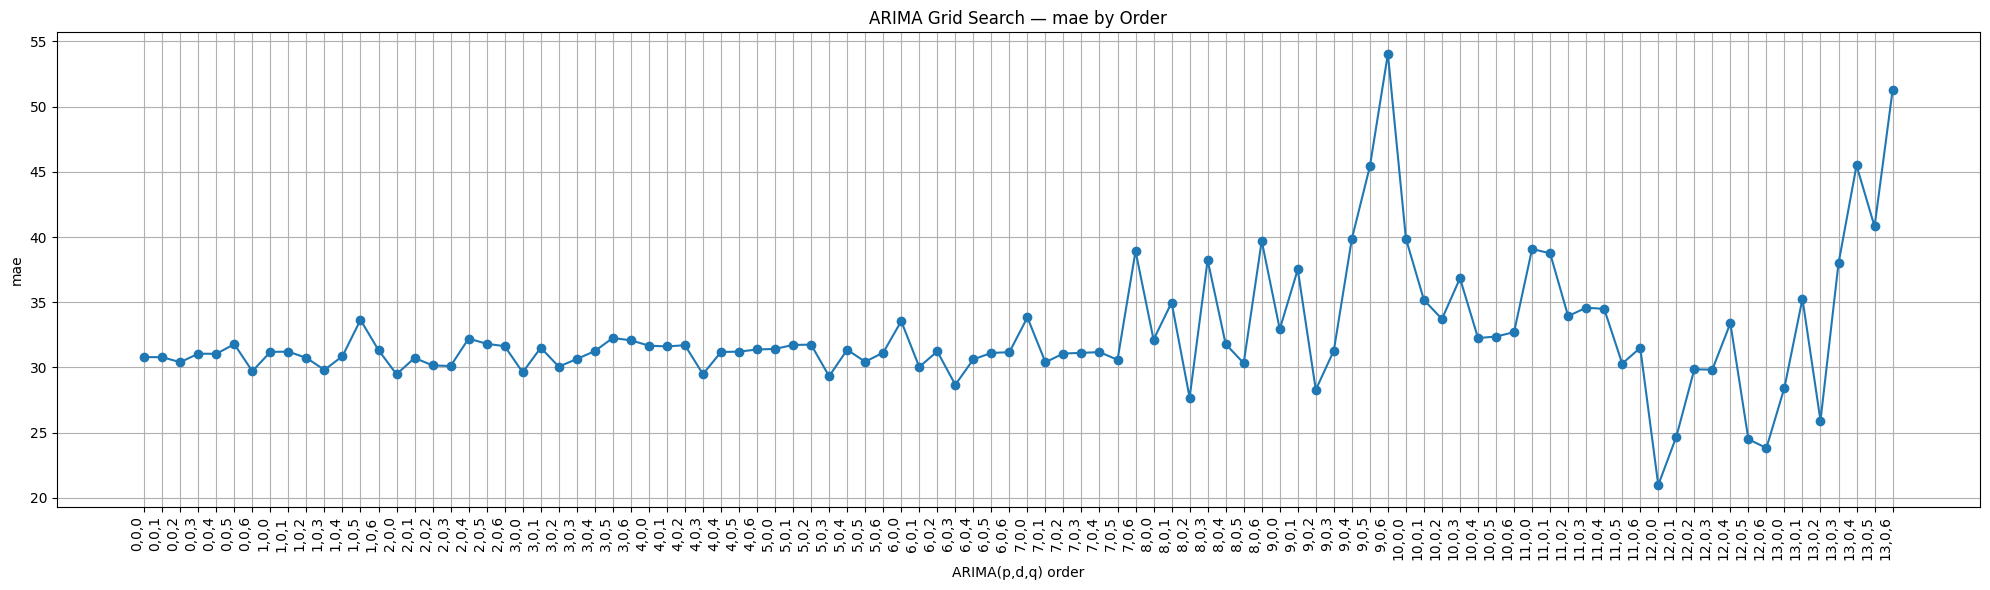

Best ARIMA order: (12, 0, 0) → mae = 20.98
Rolling-Window Forecast Evaluation:
MAE:  20.979
RMSE: 719.620
MAPE: 1.12%
R2:   0.4133


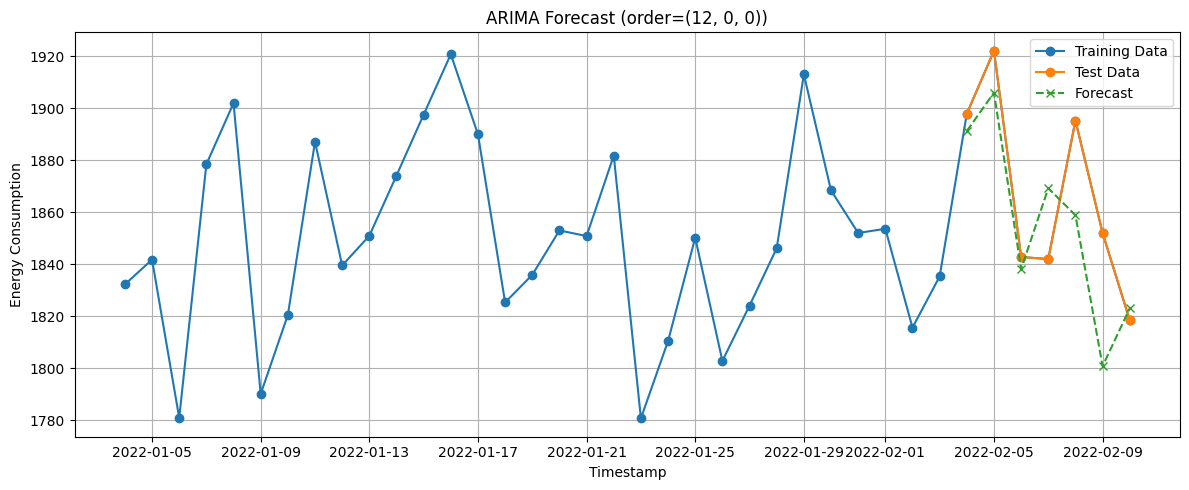

,Baseline_24h,Baseline_Daily,ARIMA_24h,ARIMA_Daily
mae,6.704103,29.422096,6.597422,20.979117
rmse,68.050988,1391.544903,64.993160,719.619933
mape,8.750275,1.557443,8.768055,1.122592
r2,-0.012465,-0.134533,0.033029,0.413290


In [13]:
# import test
train_day = df_daily.iloc[:-forecast_horizon][target_col].asfreq('D')
test_day = df_daily.iloc[-forecast_horizon:][target_col].asfreq('D')

best_order_daily, best_mape_daily, results_daily = grid_search_arima(
    train_day,
    test_day,
    p_range=range(0,14),
    d_range=[0],
    q_range=range(0,7),
    metric= 'mae'
)

df_predictions_daily = arima_model(train_day, test_day, best_order_daily)
# Evaluate and visualize
result_arima_daily = evaluate_model(df_predictions_daily, verbose=True)
title = f"ARIMA Forecast (order={best_order_daily})"
visualize_prediction(df_predictions_daily, df_daily, title, last_n_samples=64)
df_model_results['ARIMA_Daily'] = result_arima_daily
df_model_results


# Using additional features for predicting the target variable

# Feature Engineering
✅ Encode categorical variables (Holiday, DayOfWeek, HVACUsage, etc.)
Use .map() for binary, get_dummies() for multiclass with drop_first=True
✅ Add time-based features:
Hour of day
Day of week (as numeric)
Month
Weekend flag
✅ Create lag or rolling features (at least 1–2)
df['lag_1'] = df['EnergyConsumption'].shift(1)
df['rolling_mean_24'] = df['EnergyConsumption'].rolling(24).mean()
